# Import packages & functions

In [2]:
print("importing modules")
import os
import sys
import json
import argparse
import numpy as np
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds
from PIL import Image
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

import utils

import importlib.util
parent_utils_path = "/home/ri4541/mindeye_preproc/analysis/utils.py"
spec = importlib.util.spec_from_file_location("utils", parent_utils_path)
preproc = importlib.util.module_from_spec(spec)
parent_dir = os.path.dirname(parent_utils_path)  # Extract directory
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
spec.loader.exec_module(preproc)

# Can run a SLURM job array to train many models with different random seed values
try:
    seed = int(os.environ["SLURM_ARRAY_TASK_ID"])
    print(f"using random seed {seed} in SLURM job {seed} of array")
except:
    print("SLURM random seed indices not provided; using random seed = 0")
    seed = 0

if utils.is_interactive():
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

importing modules
SLURM random seed indices not provided; using random seed = 0


# Princeton data prep

## Load Data & Design

In [134]:
sub = 'sub-005'
session = 'all'
task='task-C_'  # '' (empty string) normally, task-A_ or similar otherwise
func_task_name = 'C'  # 'study' or 'A'; used to search for functional run in bids format
resample_voxel_size = False

# settings for multiple sessions
if session == "all":
    # ses_list = ["ses-01", "ses-02", "ses-03"]  # list of actual session IDs
    # design_ses_list = ["ses-01", "ses-02", "ses-03"]  # list of session IDs to search for design matrix
    ses_list = ["ses-01", "ses-03"]  # list of actual session IDs
    design_ses_list = ["ses-01", "ses-03"]  # list of session IDs to search for design matrix

else:
    ses_list = [session]
    design_ses_list = [session]
    
multi_session = False  # do you want to run GLMsingle on multiple sessions for this subject? 
ref_session = None  # None or 'ses-xx'; use the T1 from the reference session; use this only if the current session doesn't have a T1
if ref_session is not None: 
    assert multi_session is True
if ref_session is None: ref_session = session

if sub=='sub-001' and session == 'ses-01':
    n_runs=16
elif sub=='sub-002' and session == 'ses-01':
    n_runs=9
elif (sub=='sub-001' and session in ('ses-05')) or (sub=='sub-002' and session in ('ses-02')) or (sub=='sub-004' and session in ('ses-01')):
    n_runs=5
elif sub=='sub-004' and session  == 'ses-02':
    n_runs = 12
elif sub=='sub-004' and session == 'all':
    n_runs = 17
    runs_per_session = {
    "ses-01": 5,
    "ses-02": 12
    }
elif sub=='sub-005' and session in ('ses-01', 'ses-02', 'ses-03'):
    n_runs=11
elif sub=='sub-005' and session == 'all':
    runs_per_session = {
    "ses-01": 11,
    "ses-02": 11,
    "ses-03": 11
    }
    n_runs = sum(runs_per_session[ses] for ses in ses_list)
else:
    raise Exception("undefined subject and/or session")
runs_per_session = {session: n_runs} if not multi_session else runs_per_session
if multi_session: assert runs_per_session is not None
print(n_runs, "functional runs")
train_test_split = 'MST' # 'orig'
remove_close_to_MST = False
remove_random_n = False
# if remove_close_to_MST or remove_random_n:
#     assert remove_close_to_MST != remove_random_n  # don't remove both sets of images

# if remove_random_n:
#     assert train_test_split == 'MST'  # MST images are excluded from the n images removed, so only makes sense if they're not in the training set
#     n_to_remove = 150

22 functional runs


In [135]:
session_label = preproc.get_session_label(ses_list[:-1])

In [136]:
glmsingle_path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{session_label}_task-{func_task_name}"
print(glmsingle_path)
assert os.path.exists(glmsingle_path)
designdir = "/home/ri4541/real_time_mindEye2"

/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C


In [137]:
def process_images(image_names, unique_images, remove_close_to_MST=False, remove_random_n=False, imgs_to_remove=None, sub=None, session=None):
    image_idx = np.array([])
    vox_image_names = np.array([])
    all_MST_images = {}
    
    for i, im in enumerate(image_names):
        if im == "blank.jpg" or str(im) == "nan":
            continue
                
        if remove_close_to_MST and "closest_pairs" in im:
            continue
        
        if remove_random_n and im in imgs_to_remove:
            continue
            
        vox_image_names = np.append(vox_image_names, im)
        image_idx_ = np.where(im == unique_images)[0].item()
        image_idx = np.append(image_idx, image_idx_)
        
        if sub == 'ses-01' and session in ('ses-01', 'ses-04'):
            if ('w_' in im or 'paired_image_' in im or re.match(r'all_stimuli/rtmindeye_stimuli/\d{1,2}_\d{1,3}\.png$', im) 
                or re.match(r'images/\d{1,2}_\d{1,3}\.png$', im)):
                all_MST_images[i] = im
        elif 'MST' in im:
            all_MST_images[i] = im
    
    image_idx = torch.Tensor(image_idx).long()
    unique_MST_images = np.unique(list(all_MST_images.values()))
    
    MST_ID = np.array([], dtype=int)
    if remove_close_to_MST:
        close_to_MST_idx = np.array([], dtype=int)
    if remove_random_n:
        random_n_idx = np.array([], dtype=int)
    
    vox_idx = np.array([], dtype=int)
    j = 0  # Counter for indexing vox based on removed images
    
    for i, im in enumerate(image_names):
        if im == "blank.jpg" or str(im) == "nan":
            continue
        
        if remove_close_to_MST and "closest_pairs" in im:
            close_to_MST_idx = np.append(close_to_MST_idx, i)
            continue
        
        if remove_random_n and im in imgs_to_remove:
            vox_idx = np.append(vox_idx, j)
            j += 1
            continue
        
        j += 1
        curr = np.where(im == unique_MST_images)
        
        if curr[0].size == 0:
            MST_ID = np.append(MST_ID, len(unique_MST_images))  # Out of range index for filtering later
        else:
            MST_ID = np.append(MST_ID, curr)
    
    assert len(MST_ID) == len(image_idx)
    
    pairs = utils.find_paired_indices(image_idx)
    pairs = sorted(pairs, key=lambda x: x[0])
    
    return image_idx, vox_image_names, pairs

In [138]:
def get_image_pairs(sub, session, func_task_name, designdir):
    """Loads design files and processes image pairs for a given session."""
    _, _, _, _, image_names, unique_images, _ = preproc.load_design_files(
        sub=sub,
        session=session,
        func_task_name=func_task_name,
        designdir=designdir,
        design_ses_list=[session]  # Ensure it's a list
    )
    return process_images(image_names, unique_images)

In [139]:
from collections import defaultdict

In [140]:
# pairs_list = []

# if len(ses_list) > 2:
#     # Case 1: Aggregate results from multiple sessions (ses_list[:-1])
#     # Initialize dictionary where each value is a list of lists (one list per session)
#     all_pairs = defaultdict(lambda: [[] for _ in range(len(ses_list))])

#     for s_idx, s in enumerate(ses_list[:-1]):
#         image_idx, vox_image_names, pairs = get_image_pairs(sub, s, func_task_name, designdir)
#         assert len(image_idx) == len(vox_image_names)  # within session, there should be a 1-1 mapping between image names and indices

#         for idx, name in zip(image_idx, vox_image_names):
#             all_pairs[name][s_idx].append(idx)
    
#     # combined_pairs = sum([s for s in ses_list[:-1]], [])
#     # pairs_list.append(combined_pairs)

#     # Case 2: Process last session separately
#     pairs_list.append(get_image_pairs(sub, ses_list[-1], func_task_name, designdir))
#     all_pairs = dict(all_pairs)
# else:
#     # Case 3: Process both sessions individually if ses_list has only 2 entries
#     pairs_list.extend([get_image_pairs(sub, s, func_task_name, designdir) for s in ses_list])

# assert len(pairs_list) == 2

In [141]:
all_dicts = []
for s_idx, s in enumerate(ses_list):
    image_idx, vox_image_names, _ = get_image_pairs(sub, s, func_task_name, designdir)
    assert len(image_idx) == len(vox_image_names)
    all_dicts.append({k:v for k,v in enumerate(vox_image_names)})

# for the train set (ses-01-02)
image_to_indices = defaultdict(lambda: [[] for _ in range(len(ses_list[:-1]))])
for ses_idx, idx_to_name in enumerate(all_dicts[:-1]):
    for idx, name in idx_to_name.items():
        image_to_indices[name][ses_idx].append(idx)
        
image_to_indices = dict(image_to_indices)

# for the test set (ses-03)
test_image_to_indices = defaultdict(lambda: [[] for _ in range(len([ses_list[-1]]))])
for ses_idx, idx_to_name in enumerate([all_dicts[-1]]):
    for idx, name in idx_to_name.items():
        test_image_to_indices[name][ses_idx].append(idx)
        
test_image_to_indices = dict(test_image_to_indices)

Data shape: (780, 122)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-01.csv
Total number of images: 770
Number of unique images: 532
Data shape: (780, 126)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532


In [142]:
# assert len(image_to_indices.keys()) == 1000
# assert len(test_image_to_indices.keys()) == 531

In [145]:
if sub == 'sub-005' and ses_list == ['ses-01', 'ses-02', 'ses-03']:
    _tmp = utils.verify_image_patterns(image_to_indices)
    # _tmp2 = utils.verify_image_patterns(test_image_to_indices)
    try:
        assert len(_tmp) == 0
        # assert len(_tmp2) == 0
        del _tmp
    except:
        [print(i) for i in _tmp]
        # [print(i) for i in _tmp2]
        raise ValueError("invalid images for this session")

In [146]:
# x,y = get_image_pairs(sub, ses_list[0], func_task_name, designdir)
# print(x,y.shape)

In [147]:
# l1 = [item for sublist in pairs_list[0] for item in sublist]
# l2 = [item for sublist in pairs_list[1] for item in sublist]
# len([i for i in l2 if i in l1])

In [148]:
# np.max([item for sublist in pairs_list[0] for item in sublist])

In [149]:
# pairs_list

In [150]:
def get_betas(path):
    glmsingle = np.load(path, allow_pickle=True) 
    return glmsingle['betasmd'].T

### Load nsdgeneral ROI

In [151]:
def load_masks(img_list):
    masks = [nilearn.image.load_img(mask) for mask in img_list]
    assert all(np.allclose(masks[0].affine, m.affine) for m in masks)
    return masks, intersect_masks(masks, threshold=0.5, connected=True)

In [152]:
def get_mask(ses_list, sub, func_task_name):
    assert len(ses_list) > 1
    mask_imgs = []
    nsd_imgs = []
    for ses in ses_list:
        prefix = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{ses}_task-{func_task_name}/{sub}_{ses}_task-{func_task_name}"
        mask_path = prefix + "_brain.nii.gz"
        nsd_path = prefix + "_nsdgeneral.nii.gz"
        print(mask_path)
        print(nsd_path)
        assert os.path.exists(mask_path)
        assert os.path.exists(nsd_path)
        mask_imgs.append(mask_path)
        nsd_imgs.append(nsd_path)

    func_masks, avg_mask = load_masks(mask_imgs)
    print(f'intersected brain masks from {ses_list}')
    
    nsd_masks, roi = load_masks(nsd_imgs)
    print(f'intersected nsdgeneral roi masks from {ses_list}')

    return func_masks, avg_mask, nsd_masks, roi

creating multisession brain mask
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C/sub-005_ses-01_task-C_brain.nii.gz
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-01_task-C/sub-005_ses-01_task-C_nsdgeneral.nii.gz
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-03_task-C/sub-005_ses-03_task-C_brain.nii.gz
/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_sub-005_ses-03_task-C/sub-005_ses-03_task-C_nsdgeneral.nii.gz
intersected brain masks from ['ses-01', 'ses-03']
intersected nsdgeneral roi masks from ['ses-01', 'ses-03']
Mask dimensions: (2.0, 2.0, 2.0)

Affine:
[[  2.           0.           0.         -76.29234314]
 [  0.           2.           0.         -84.79180908]
 [  0.           0.           2.         -62.80359268]
 [  0.           0.           0.           1.        ]]

There are 181268 voxels in the included brain mask



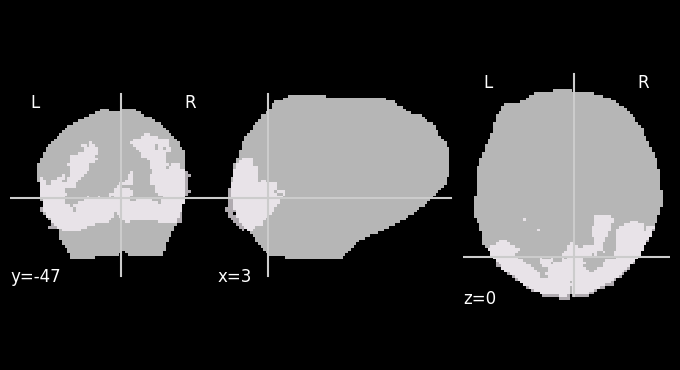

In [153]:
from nilearn.plotting import plot_roi, plot_anat, plot_epi
from nilearn.masking import intersect_masks
import nilearn

# avg_mask=nib.load(f'{sub}_ses-01_brain.nii.gz')
assert session == "all"
if len(ses_list) == 2:
        print('creating multisession brain mask')
        func_masks, avg_mask, nsd_masks, roi = get_mask(ses_list, sub, func_task_name)
else:
    assert len(ses_list) > 2
    print('loading brain mask')
    func_masks, avg_mask, nsd_masks, roi = get_mask([session_label, ses_list[-1]], sub, func_task_name)

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {int(np.sum(brain))} voxels in the included brain mask\n')

plot_roi(roi, bg_img=avg_mask)
plt.show()

In [154]:
if session == "all" and len(ses_list) == 2:
    vox_list = []
    for s in ses_list:
        path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{s}_task-{func_task_name}/TYPED_FITHRF_GLMDENOISE_RR.npz"
        vox_list.append(get_betas(path))
        
        print(f"Loaded session: {s} | Current shape: {vox_list[-1].shape}")
else:
    assert len(ses_list) > 2
    vox_list = []
    path = f"{glmsingle_path}/TYPED_FITHRF_GLMDENOISE_RR.npz"
    vox_list.append(get_betas(path))
    print(f"Loaded session: {session_label} | Current shape: {vox_list[-1].shape}")
    path = f"/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_{sub}_{ses_list[-1]}_task-{func_task_name}/TYPED_FITHRF_GLMDENOISE_RR.npz"
    vox_list.append(get_betas(path))
    print(f"Loaded session: {ses_list[-1]} | Current shape: {vox_list[-1].shape}")

Loaded session: ses-01 | Current shape: (693, 1, 1, 182242)
Loaded session: ses-03 | Current shape: (693, 1, 1, 183408)


In [155]:
# def get_masked_betas(ses_list, vox_list, func_masks, avg_mask, roi):
#     masked_betas = []
#     for i, s in enumerate(vox_list):
#         v = nilearn.masking.unmask(vox_list[i][:,0,0], func_masks[i])
#         final_mask = nilearn.masking.intersect_masks([avg_mask, roi])
#         masked_betas.append(nilearn.masking.apply_mask(v, final_mask))
        
#     vox = np.concatenate(masked_betas)
#     print('vox shape:', vox.shape)
    
#     return final_mask, masked_betas, vox

In [156]:
# if session == 'all':
#     assert len(vox_list) == 2
#     final_mask, masked_betas, vox = get_masked_betas(ses_list, vox_list, func_masks, avg_mask, roi)
# # elif len(ses_list) > 2:
# #     final_mask, masked_betas, vox = get_masked_betas(ses_list[:-1], vox_list, func_masks, avg_mask, roi)

In [157]:
if session == 'all':
    ses_vox = []
    for i, s in enumerate([session_label, ses_list[-1]]):
        v = nilearn.masking.unmask(vox_list[i][:,0,0], func_masks[i])
        final_mask = nilearn.masking.intersect_masks([avg_mask, roi])
        ses_vox.append(nilearn.masking.apply_mask(v, final_mask))
        
    vox = np.concatenate(ses_vox)
    print('vox shape:', vox.shape)

vox shape: (1386, 19233)


In [186]:
train_pairs_list = []
test_pairs_list = []

if sub == 'sub-005' and ses_list == ["ses-01", "ses-02", "ses-03"]:
    for image, (ses0_indices, ses1_indices) in image_to_indices.items():
        # Offset session 1 indices by 693
        ses1_indices_offset = [i + 693 for i in ses1_indices]

        # Combine all repeat indices (across both sessions)
        all_indices = ses0_indices + ses1_indices_offset

        # Only include if there are at least 2 repeats
        if len(all_indices) >= 2:
            train_pairs_list.append(all_indices)
        
    for i in test_image_to_indices.values():
        # print(i[0])
        # Only include if there are at least 2 repeats
        if len(i[0]) >= 2:
            test_pairs_list.append(i[0])
            
    train_test_pairs = [train_pairs_list, test_pairs_list]
            
elif sub == 'sub-005' and ses_list == ["ses-01", "ses-03"]:
    pairs_list = []

    if len(ses_list) > 2:
        # Case 1: Aggregate results from multiple sessions (ses_list[:-1]), concatenating into a single list
        combined_pairs = sum([get_image_pairs(sub, s, func_task_name, designdir) for s in ses_list[:-1]], [])
        pairs_list.append(combined_pairs)

        # Case 2: Process last session separately
        pairs_list.append(get_image_pairs(sub, ses_list[-1], func_task_name, designdir))

    else:
        # Case 3: Process both sessions individually if ses_list has only 2 entries
        pairs_list.extend([get_image_pairs(sub, s, func_task_name, designdir) for s in ses_list])

    assert len(pairs_list) == 2

Data shape: (780, 122)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-01.csv
Total number of images: 770
Number of unique images: 532
Data shape: (780, 126)
Using design file: /home/ri4541/real_time_mindEye2/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532


In [161]:
# train_test_pairs[0][:5]

In [162]:
# ses_vox[0].shape, train_test_pairs[0][:5]

In [163]:
# tmp = [(i[0],i[-1]) for i in train_test_pairs[0]]
# np.mean(vox[tmp], axis=0)

In [164]:
# tmp = [(i[0],i[1]) for i in train_test_pairs[0]]
# np.mean(vox[tmp], axis=0)

In [165]:
# vox[tmp].shape  # (n_images [that have repeats], n_repeats [using only 2], n_voxels)

In [166]:
# import math
# math.factorial(4) // (math.factorial(2) * math.factorial(4 - 2))

In [167]:
# def calculate_combinations(x, y):
#   """Calculates x choose y (xCy) using the formula."""
#   if y > x or y < 0:
#     return 0  # Handle invalid input
#   return math.factorial(x) // (math.factorial(y) * math.factorial(x - y))

In [168]:
# def compute_voxelwise_reliability(vox_z, pairs):
#     """
#     Compute voxelwise reliability as mean pairwise pattern correlations across repeats.
    
#     Parameters:
#     - vox_z: np.ndarray, shape (n_images, n_voxels), z-scored voxel patterns
#     - pairs: list of lists of ints, each sublist = indices of repeats for a unique image

#     Returns:
#     - rels: np.ndarray, shape (n_voxels,), mean reliability per voxel
#     """
#     from itertools import combinations
#     voxel_corrs = [[] for _ in range(vox_z.shape[1])]

#     for repeat_idxs in pairs:
#         if len(repeat_idxs) < 2:
#             continue
#         print(repeat_idxs)
#         for idx, (i, j) in enumerate(combinations(repeat_idxs, 2)):
#             xi = vox_z[i]
#             xj = vox_z[j]
#             voxel_corrs[idx].append((xi, xj))
#             print(voxel_corrs[idx])
#             assert len(voxel_corrs[idx]) == calculate_combinations(len(repeat_idxs), 2)
#         print(voxel_corrs[idx].shape)
#         print()

#     rels = np.full(vox_z.shape[1], np.nan)
#     for v in range(vox_z.shape[1]):
#         if len(voxel_corrs[v]) >= 2:
#             x, y = zip(*voxel_corrs[v])
#             rels[v] = np.corrcoef(x, y)[0, 1]

#     rels = np.array([
#         np.mean(corrs) if corrs else np.nan
#         for corrs in voxel_corrs
#     ])
#     return rels

In [169]:
# # First, build a mapping from original index → new row index in vox_z
# repeated_idxs = np.concatenate(train_test_pairs[0])
# idx_map = {orig_idx: new_idx for new_idx, orig_idx in enumerate(repeated_idxs)}

# # Then remap pairs to point into vox_z
# pairs_mapped = [[idx_map[i] for i in group if i in idx_map] for group in train_test_pairs[0]]

In [170]:
# vox_z = utils.zscore(vox[repeated_idxs])
# rels = compute_voxelwise_reliability(vox_z, pairs_mapped)

In [171]:
# [print(i) for i in rels]
# np.mean(rels), np.std(rels), np.min(rels), np.max(rels)

In [172]:
# ses_rels = []

# for i, s in enumerate([session_label, ses_list[-1]]):
#     ses_rels.append(utils.compute_vox_rels(ses_vox[i], train_test_pairs[i], sub, s, rdm=False))

In [190]:
ses_rels = []
if sub == 'sub-005' and ses_list == ['ses-01', 'ses-02', 'ses-03']:
    repeat_combinations = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

    for i, s in enumerate([session_label, ses_list[-1]]):
        print(ses_vox[i].shape)

        # Calculate relationships for each combination of repeats
        combo_rels = []
        for combo in repeat_combinations:
            try:
                rel = utils.compute_vox_rels(ses_vox[i], train_test_pairs[i], sub, s, rdm=False, repeat_indices=combo)
                combo_rels.append(rel)
            except IndexError:
                # Skip combinations that aren't available (e.g., if only 2 repeats exist)
                continue

        # Average the relationships across all valid combinations
        if combo_rels:
            avg_rel = np.mean(combo_rels, axis=0)
            ses_rels.append(avg_rel)
        else:
            # Fallback to original behavior if no combinations worked
            rels = compute_vox_rels(ses_vox[i], pairs_list[i], sub, s, (0, 1))
            ses_rels.append(rels)
elif sub == 'sub-005' and ses_list == ['ses-01', 'ses-03']:
    repeat_combinations = [(0, 1), (0, 2), (1, 2)]

    for i, s in enumerate([session_label, ses_list[-1]]):
        print(ses_vox[i].shape)

        # Calculate relationships for each combination of repeats
        combo_rels = []
        for combo in repeat_combinations:
            try:
                rel = utils.compute_vox_rels(ses_vox[i], pairs_list[i], sub, s, repeat_indices=combo)
                combo_rels.append(rel)
            except IndexError:
                # Skip combinations that aren't available (e.g., if only 2 repeats exist)
                continue

        # Average the relationships across all valid combinations
        if combo_rels:
            avg_rel = np.mean(combo_rels, axis=0)
            ses_rels.append(avg_rel)
        else:
            # Fallback to original behavior if no combinations worked
            rels = compute_vox_rels(ses_vox[i], pairs_list[i], sub, s, (0, 1))
            ses_rels.append(rels)

(693, 19233)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3, 2) + inhomogeneous part.

In [131]:
ses_rels

[array([0.09947975, 0.08679556, 0.14701401, ..., 0.12509059, 0.13106931,
        0.1303709 ]),
 array([0.18833964, 0.25356982, 0.33014686, ..., 0.23515568, 0.29471   ,
        0.19608378])]

In [132]:
print(ses_rels[0].min(), ses_rels[0].max(), ses_rels[0].mean(), ses_rels[0].std())
print(ses_rels[1].min(), ses_rels[1].max(), ses_rels[1].mean(), ses_rels[1].std())

-0.03723609748451917 0.371823264594652 0.12027648058903848 0.05106661521322093
0.04814177721562161 0.7278723377959632 0.2994669813826024 0.08444980979174319


threshold -0.2: 19281 voxels
threshold -0.1: 19281 voxels
threshold 0.0: 19251 voxels
threshold 0.1: 12151 voxels
threshold 0.2: 1350 voxels
threshold 0.3: 68 voxels
threshold 0.4: 0 voxels
threshold 0.5: 0 voxels


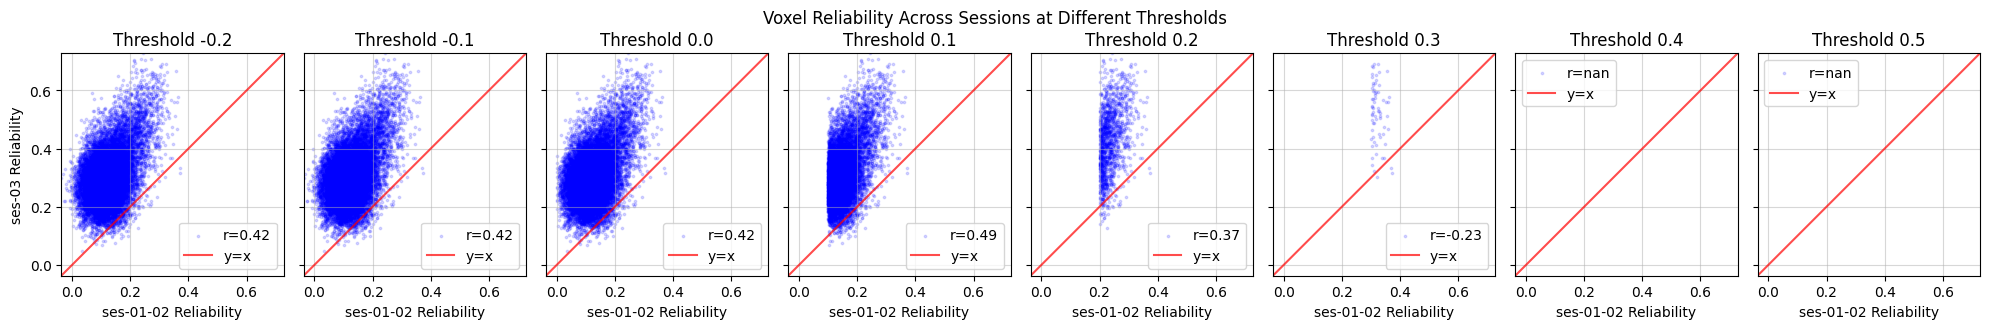

In [133]:
from matplotlib.ticker import MaxNLocator

r_thresholds = np.arange(-0.2, 0.6, 0.1)

# Determine global axis limits
reliability_min = min(ses_rels[0].min(), ses_rels[1].min())
reliability_max = max(ses_rels[0].max(), ses_rels[1].max())

# Create subplots
fig, axes = plt.subplots(1, len(r_thresholds), figsize=(20,3), sharex=True, sharey=True)

masks = []
for i, thresh in enumerate(r_thresholds):
    mask = ses_rels[0] > thresh
    masks.append(mask)
    x = ses_rels[0][mask]  # threshold reliability based on ses-01
    y = ses_rels[1][mask]  # compare to ses-02 reliabilities but using the ses-01 threshold
    print(f"threshold {thresh:.1f}: {x.shape[0]} voxels")
    
    assert x.shape == y.shape
    corr = np.corrcoef(x,y)[0,1]
    
    # Scatter plot
    axes[i].scatter(x, y, alpha=0.15, s=3, color='blue', label=f'r={corr:.2f}')
    
    axes[i].axline((0, 0), slope=1, color='r', alpha=0.7, label="y=x")

    # Set square aspect ratio and equal axis limits
    axes[i].set_xlim(reliability_min, reliability_max)
    axes[i].set_ylim(reliability_min, reliability_max)
    axes[i].set_aspect('equal', adjustable='box')  # Ensures square plots

    # Set tick marks to be evenly spaced
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5))

    # Labels and title
    axes[i].set_title(f"Threshold {thresh:.1f}")
    axes[i].set_xlabel(f"{session_label} Reliability")
    if i == 0:
        axes[i].set_ylabel(f"{ses_list[-1]} Reliability")
    
    axes[i].legend()
    axes[i].grid(alpha=0.5)

plt.suptitle("Voxel Reliability Across Sessions at Different Thresholds")
plt.tight_layout()
plt.show()

19281 voxels in ses-03 with reliability > 0.0 (no threshold)
19261 voxels in ses-03 with reliability > 0.1 (no threshold)
17589 voxels in ses-03 with reliability > 0.2 (no threshold)
8501 voxels in ses-03 with reliability > 0.3 (no threshold)
2116 voxels in ses-03 with reliability > 0.4 (no threshold)


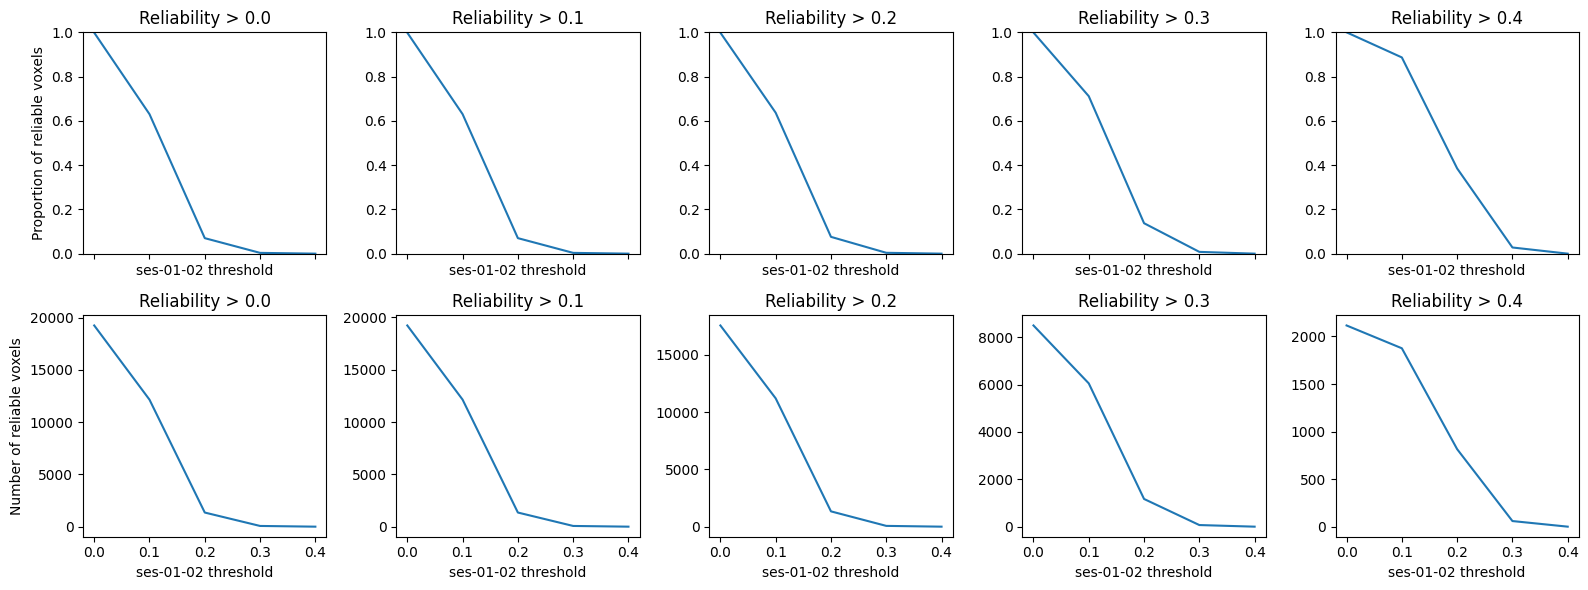

In [121]:
# x_thresholds = [0.1, 0.2, 0.25, 0.3, 0.35, 0.4]
x_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]
y_thresholds = x_thresholds

x = ses_rels[0]
y = ses_rels[1]

fig, ax = plt.subplots(2, len(x_thresholds), figsize=(16, 6), sharex=True)

for i, y_thresh in enumerate(y_thresholds):
    baseline = np.sum(y > y_thresh)
    print(f'{baseline} voxels in ses-03 with reliability > {y_thresh} (no threshold)')

    all_prop, all_num = [], []
    for x_thresh in x_thresholds:
        num = np.sum(y[np.where(x > x_thresh)] > y_thresh)
        all_prop.append(num / baseline)
        all_num.append(num)

    # Plot proportion
    ax[0, i].plot(x_thresholds, all_prop)
    ax[1, i].plot(x_thresholds, all_num)

    for j, label in enumerate(["Proportion of reliable voxels", "Number of reliable voxels"]):
        ax[j, i].set_title(f'Reliability > {y_thresh}')
        ax[j, i].set_xlabel(f'{session_label} threshold')
        if i == 0:
            ax[j, i].set_ylabel(label)

    for a in ax[0, :]:  
        a.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
for i, y_thresh in enumerate(y_thresholds):
    baseline = np.sum(y>y_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {x_thresh} without on/off r^2 threshold')
    all_prop = []
    for x_thresh in x_thresholds:
        num = np.sum(y[np.where(x>x_thresh)]>y_thresh)
        # print(num)
        prop = num/baseline
        # print(f'{prop:.2%} voxels with reliability > {rel_thresh} at on/off r^2 > {r2_thresh}')
        # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
        all_prop.append(prop)
    ax[i].plot(x_thresholds, all_prop)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('proportion of reliable voxels remaining')
    ax[i].set_title(f'reliability > {y_thresh}')
plt.tight_layout()
plt.show()

In [ ]:
# how many of the reliable voxels from the held-out session remain at each threshold? 
fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=False)
for i, y_thresh in enumerate(y_thresholds):
    baseline = np.sum(y>y_thresh)  # how many voxels are reliable (r > 0.2) without a threshold on y? 
    print(f'{baseline} voxels in ses-03 with reliability > {y_thresh} without threshold')
    all_num = []
    for x_thresh in x_thresholds:
        num = np.sum(y[np.where(x>x_thresh)]>y_thresh)
        all_num.append(num)
    ax[i].plot(x_thresholds, all_num)
    ax[i].set_xlabel('training data threshold')
    if i == 0:
        ax[i].set_ylabel('raw number of reliable voxels remaining')
    ax[i].set_title(f'reliability > {y_thresh}')
plt.tight_layout()
plt.show()

In [ ]:
err

In [ ]:
p = f"{glmsingle_path}/rel_mask_from_{ses_list[0]}_{sub}_{session_label}_task-{func_task_name}.npy"
np.save(p, masks)
print(f'saved to {p}!')

In [ ]:
np.mean(reliable_vox0, axis=0).shape

In [ ]:
np.mean(reliable_vox0, axis=0)

In [ ]:
x = np.mean(reliable_vox0, axis=0)
y = np.mean(reliable_vox1, axis=0)

# Scatterplot
plt.figure(figsize=(7, 6))
plt.scatter(x, y, alpha=0.6, edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), label='best fit')
plt.xlabel("Voxelwise Reliability (Session 1)")
plt.ylabel("Voxelwise Reliability (Session 2)")
plt.title("Voxelwise Reliability Across Sessions")
plt.axline((0, 0), slope=1, color='r', linestyle="--", label="y=x (Perfect Agreement)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
reliability_min = min(ses_rels[0].min(), ses_rels[1].min())
reliability_max = max(ses_rels[0].max(), ses_rels[1].max())

# Create subplots
fig, axes = plt.subplots(1, len(r_thresholds), figsize=(15, 4), sharex=True, sharey=True)

for i, thresh in enumerate(r_thresholds):
    # Select voxels that pass the threshold
    mask = ses_rels[0] > thresh
    x_thresh = ses_rels[0][mask]  # Reliability from session 0
    y_thresh = ses_rels[1][mask]  # Corresponding reliability from session 1

    # Compute correlation
    corr_coef = np.corrcoef(x_thresh, y_thresh)[0, 1]

    # Scatter plot
    sns.scatterplot(x=x_thresh, y=y_thresh, ax=axes[i], alpha=0.5, s=10, color='blue')

    # Best-fit line using polyfit/poly1d
    poly_fit = np.poly1d(np.polyfit(x_thresh, y_thresh, 1))
    axes[i].plot(np.unique(x_thresh), poly_fit(np.unique(x_thresh)), color='black', alpha=0.5)

    # Set square aspect ratio and equal axis limits
    axes[i].set_xlim(reliability_min, reliability_max)
    axes[i].set_ylim(reliability_min, reliability_max)
    axes[i].set_aspect('equal', adjustable='box')  # Ensures square plots

    # Set tick marks to be evenly spaced
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=5))
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5))

    # Labels and title
    axes[i].set_title(f"Threshold {thresh}\nCorr = {corr_coef:.2f}")
    axes[i].set_xlabel("Session 0 Reliability")
    if i == 0:
        axes[i].set_ylabel("Session 1 Reliability")

# Final layout adjustments
plt.suptitle("Voxel Reliability Across Sessions at Different Thresholds")
plt.tight_layout()
plt.show()

## does on/off r2 correlate with final reliability estimates?

In [ ]:
def np2nib(data, mask):
    data_3d = np.zeros(mask.get_fdata().shape)  # shape includes voxels outside the brain
    data_3d[mask.get_fdata()!=0] = data  # fill the nonzero values (the ones in the brain) with the data; filter voxels that are in the brain
    return nib.Nifti1Image(data_3d, mask.affine)  # convert to nibabel object and return

In [ ]:
# on_off['onoffR2'].shape, rels.shape, avg_mask.shape

In [ ]:
# load on/off r2 and convert to nifti image using avg_mask affine
on_off = np.load(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01_paul/TYPEA_ONOFF.npz', allow_pickle=True)
avg_mask=nib.load(f'/scratch/gpfs/ri4541/MindEyeV2/src/mindeyev2/glmsingle_ses-01_paul/sub-001_ses-01_brain.nii.gz')

onoff_nib = np2nib(on_off['onoffR2'], avg_mask)
# onoff_nib = np2nib(utils.zscore(on_off['onoffR2']), avg_mask)

# get reliability mask from above
rels_nib = np2nib(rels, avg_mask)
# rels_nib = np2nib(utils.zscore(rels), avg_mask)

# confirm they're both in the same space

# plot both 
fig,ax=plt.subplots(1,1, figsize=(10,4))
d1 = plot_roi(onoff_nib, bg_img=avg_mask, axes=ax)
sm = plt.cm.ScalarMappable(cmap='gist_ncar', norm=plt.Normalize(vmin=onoff_nib.get_fdata().min(), vmax=onoff_nib.get_fdata().max()))
sm.set_array([])  # Required for color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
ax.set_title('onoff')
plt.show()

fig,ax=plt.subplots(1,1, figsize=(10,4))
d2 = plot_roi(rels_nib, bg_img=avg_mask, axes=ax)
sm = plt.cm.ScalarMappable(cmap='gist_ncar', norm=plt.Normalize(vmin=rels_nib.get_fdata().min(), vmax=rels_nib.get_fdata().max()))
sm.set_array([])  # Required for color bar
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)
ax.set_title('reliability')
plt.show()

In [ ]:
rels_nib.get_fdata().shape

In [ ]:
np.where(rels_nib.get_fdata()!=0)[0]

In [ ]:
on_off

In [ ]:
np.corrcoef(onoff_nib.get_fdata().flatten(), rels_nib.get_fdata().flatten())[0,1]

In [ ]:
print(f"onoff range: ({on_off['onoffR2'].min():.3f}, {on_off['onoffR2'].max():.3f})")
print(f"rels range: ({rels.min():.3f}, {rels.max():.3f})")

In [ ]:
glmsingle = np.load(f"{glmsingle_path}/TYPED_FITHRF_GLMDENOISE_RR.npz",allow_pickle=True) 
vox = glmsingle['betasmd'].T
vox.shape

## Is there an on/off r^2 threshold that isolates the majority of reliable voxels?

In [ ]:
# scatterplot of r^2 threshold vs reliability
print(on_off['onoffR2'].shape, rels.shape)
x = on_off['onoffR2']
y = rels

r2_thresh = 0
mask = np.where(x>=r2_thresh)
x_thresh = x[mask]; y_thresh = y[mask]

plt.scatter(x_thresh, y_thresh, s=.5, alpha=1)
# for threshold in np.arange(0,40,10):
#     plt.axvline(x=threshold, color='red', linestyle='--', alpha=.35, label=f"Threshold = {threshold}")
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.plot(np.unique(x_thresh), np.poly1d(np.polyfit(x_thresh, y_thresh, 1))(np.unique(x_thresh)), color='black', alpha=.5)
plt.xlabel('on/off r^2')
plt.ylabel('reliability (pearson r)')
plt.show()

In [ ]:
plt.scatter(x, y, s=.5, alpha=1)
# for threshold in np.arange(0,40,10):
#     plt.axvline(x=threshold, color='red', linestyle='--', alpha=.35, label=f"Threshold = {threshold}")
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='black', alpha=.5)
plt.xlabel('on/off r^2')
plt.ylabel('reliability (pearson r)')
plt.show()

In [ ]:
# at each onoff r2 threshold, what percentage of total voxels remain? 
r2_thresholds = np.linspace(0,50,1000)
# print('r2 thresh: proportion of voxels left (raw #)')
all_prop = []
for thresh in r2_thresholds:
    mask = np.where(x>=thresh)
    prop = x[mask].shape[0]/x.shape[0]
    # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
    all_prop.append(prop)
plt.plot(r2_thresholds, all_prop)
plt.xlabel('on/off r^2 threshold')
plt.ylabel('proportion of total voxels remaining')
plt.show()

In [ ]:
baseline = np.sum(y>0.2)
print(f'baseline: {baseline} voxels with reliability > 0.2')
for r2 in np.arange(0,20,.5):
    num = np.sum(y[np.where(x>r2)]>0.2)
    print(f'{num} voxels ({(num/baseline):.2%}) with r^2 > {r2:.2f}')
    

In [ ]:
# at each onoff r2 threshold, what percentage of total voxels remain, normalized by the number of reliable voxels at that same threshold? 
r2_thresholds = np.linspace(0,50,100000)
rel_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=True)
for i, rel_thresh in enumerate(rel_thresholds):
    baseline = np.sum(y>rel_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {rel_thresh} without on/off r^2 threshold')
    all_prop = []
    for r2_thresh in r2_thresholds:
        num = np.sum(y[np.where(x>r2_thresh)]>rel_thresh)
        # print(num)
        prop = num/baseline
        # print(f'{prop:.2%} voxels with reliability > {rel_thresh} at on/off r^2 > {r2_thresh}')
        # print(f'{thresh:.2f}: {prop:.2%} ({x[mask].shape[0]})')
        all_prop.append(prop)
    ax[i].plot(r2_thresholds, all_prop)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('proportion of reliable voxels remaining')
    ax[i].set_title(f'reliability > {rel_thresh}')
plt.tight_layout()
plt.show()

In [ ]:
# at each onoff r2 threshold, what percentage of total voxels remain, normalized by the number of reliable voxels at that same threshold? 
r2_thresholds = np.linspace(0,50,1000)
rel_thresholds = [0.0, 0.1, 0.2, 0.3, 0.4]

fig, ax = plt.subplots(1, 5, figsize=(16, 4), sharey=False)
for i, rel_thresh in enumerate(rel_thresholds):
    baseline = np.sum(y>rel_thresh)  # how many voxels are reliable (r > 0.2) without an on/off r^2 threshold? 
    print(f'{baseline} voxels with reliability > {rel_thresh} without on/off r^2 threshold')
    all_num = []
    for r2_thresh in r2_thresholds:
        num = np.sum(y[np.where(x>r2_thresh)]>rel_thresh)
        all_num.append(num)
    ax[i].plot(r2_thresholds, all_num)
    ax[i].set_xlabel('on/off r^2 threshold')
    if i == 0:
        ax[i].set_ylabel('raw number of reliable voxels remaining')
    ax[i].set_title(f'reliability > {rel_thresh}')
plt.tight_layout()
plt.show()